In [1]:
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import models
import segmentation_models_pytorch as smp

from scripts.data_processing import (CustomDataset, create_dataset, get_train_test_valid_lable, 
                                     get_image_transforms, get_mask_transforms)
from scripts.image_processing import show_image_and_mask, visualize_predictions
from scripts.model_processing import train_and_evaluate

d:\MLE\Brain_MRI\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Создаем датасеты

Использовался датасет [Brain MRI segmentation](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation)

In [2]:
# распределяем фалы по датасету
files_df = create_dataset(path = 'data/Brain_MRI_segmentation/')

# у нас на одного пациента несколько снимков, и 
# рядом стоящие срезы могут попасть в тестовые и тренировочные датасеты
# что приведет к утечке данных. Распределяем по датасетам пациентов, а не снимки
files_df['label'] = files_df.apply(lambda row: get_train_test_valid_lable(row), axis=1)

# теперь разделяем датасеты и перемешиваем на всякий случай
train_df = files_df[files_df['label'] == 'train'].sample(frac=1).reset_index(drop=True)
test_df = files_df[files_df['label'] == 'test'].sample(frac=1).reset_index(drop=True)
valid_df = files_df[files_df['label'] == 'valid'].sample(frac=1).reset_index(drop=True)

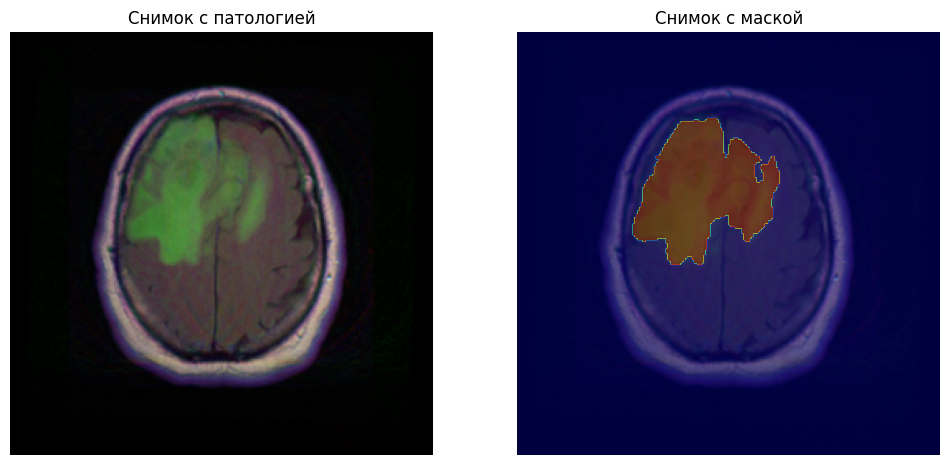

In [3]:
# выводим изображение и маску для случайного изображения,
# чтобы убедиться, что мы ничего не сломали 
path = train_df[train_df['PATHOLOGY_LABEL'] == 1]
show_image_and_mask(path.iloc[random.randint(0, len(path))])

## Преобразовываем данные для PyTorch

In [4]:
# устанавливаем устройтсво CUDA и проверяем, что все работает
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'device: {device}')

device: cuda


In [5]:
# Создание преобразований
train_transform = get_image_transforms()
mask_transform = get_mask_transforms()

# Создание датасетов
train_dataset = CustomDataset(train_df, image_transform=train_transform, mask_transform=mask_transform)
test_dataset = CustomDataset(test_df, image_transform=train_transform, mask_transform=mask_transform)
val_dataset = CustomDataset(valid_df, image_transform=train_transform, mask_transform=mask_transform)

# Использование DataLoader для пакетной загрузки данных
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## DeepLabV3 + ResNet50

In [6]:
# Создаем модель DeepLabV3 с ResNet50 и добавляем полносвязный слой для бинарной классификации
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)
model = model.to(device)

# Оптимизатор и функция потерь
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)

d:\MLE\Brain_MRI\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\MLE\Brain_MRI\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Эпоха 1 из 50: train_loss=0.22332, test_loss=0.08383, val_loss=0.08326, val_IoU=0.57434,
Эпоха 2 из 50: train_loss=0.04953, test_loss=0.03828, val_loss=0.03537, val_IoU=0.61034,
Эпоха 3 из 50: train_loss=0.02553, test_loss=0.02448, val_loss=0.02186, val_IoU=0.70118,
Эпоха 4 из 50: train_loss=0.01586, test_loss=0.01885, val_loss=0.01747, val_IoU=0.73043,
Эпоха 5 из 50: train_loss=0.01219, test_loss=0.0161, val_loss=0.01536, val_IoU=0.71334,
Эпоха 6 из 50: train_loss=0.01208, test_loss=0.01388, val_loss=0.01356, val_IoU=0.73594,
Эпоха 7 из 50: train_loss=0.00846, test_loss=0.01329, val_loss=0.01345, val_IoU=0.73467,
Эпоха 8 из 50: train_loss=0.00716, test_loss=0.01241, val_loss=0.01211, val_IoU=0.74502,
Эпоха 9 из 50: train_loss=0.0068, test_loss=0.01392, val_loss=0.01362, val_IoU=0.71099,
Эпоха 10 из 50: train_loss=0.00622, test_loss=0.01263, val_loss=0.01145, val_IoU=0.75585,
Эпоха 11 из 50: train_loss=0.00551, test_loss=0.012, val_loss=0.01392, val_IoU=0.71026,
Эпоха 12 из 50: train_l

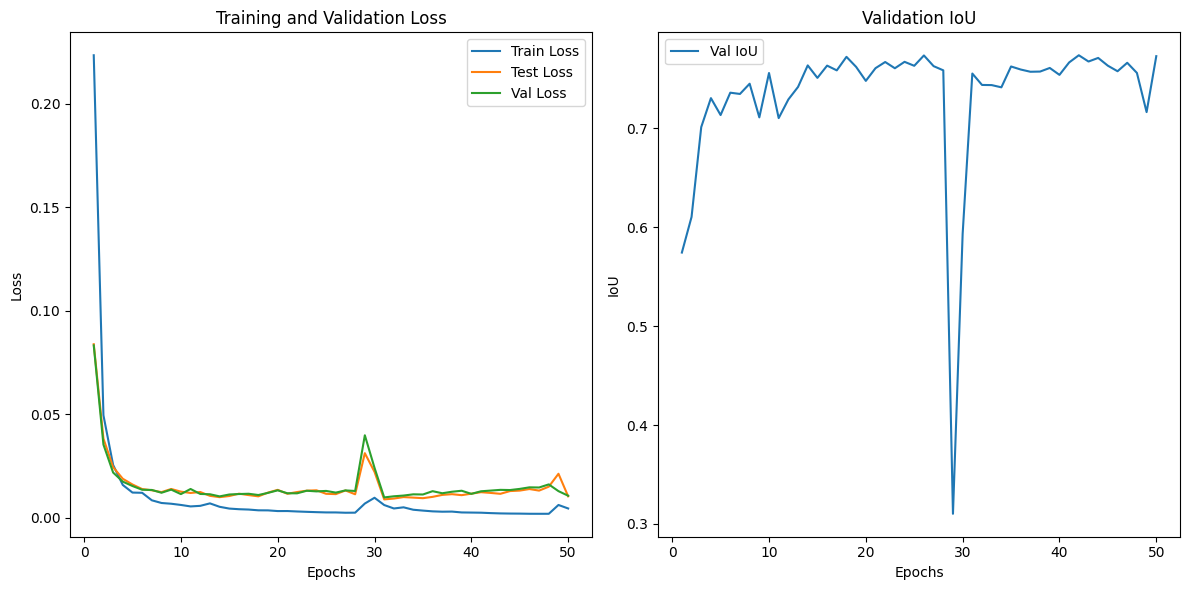

In [7]:
# обучаем модель сохраняя наилучший вариант
train_and_evaluate(model = model, model_name = 'DeepLabV3_ResNet50', 
                   num_epochs = 50, train_loader = train_loader, 
                   test_loader = test_loader, val_loader = val_loader, 
                   optimizer = optimizer, criterion = criterion, device = device)

*Выводим прогноз*

C:\Temp\ipykernel_12736\1006992313.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('models\DeepLabV3_ResNet50_best_model.pth', map_location=devic

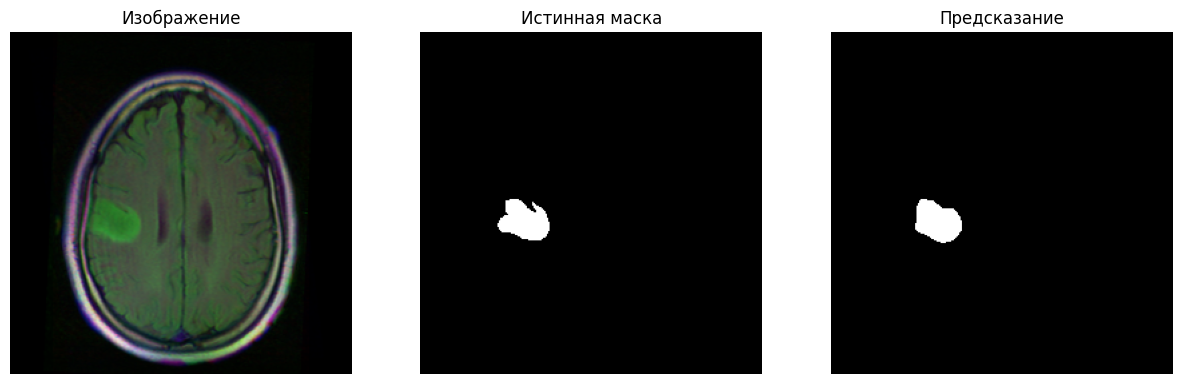

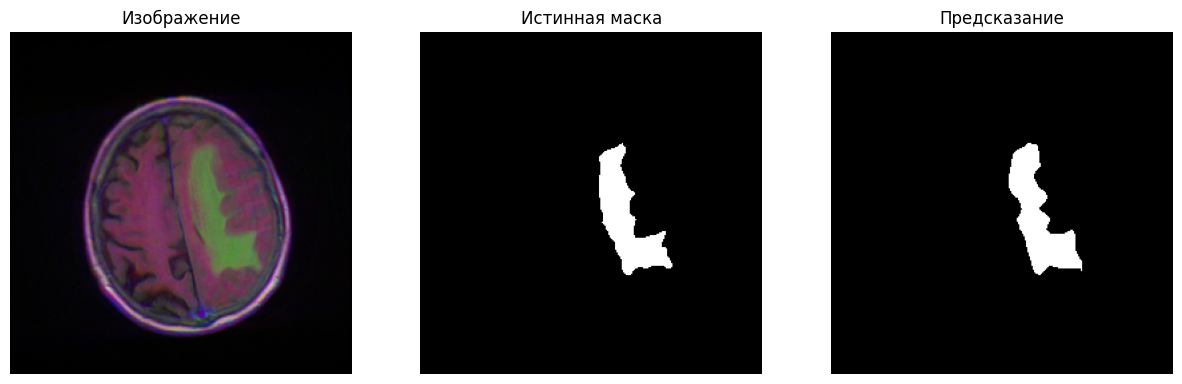

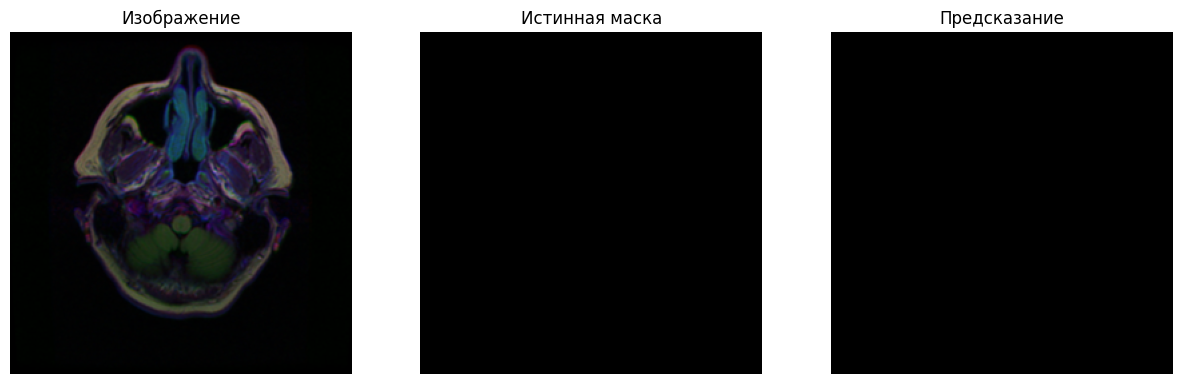

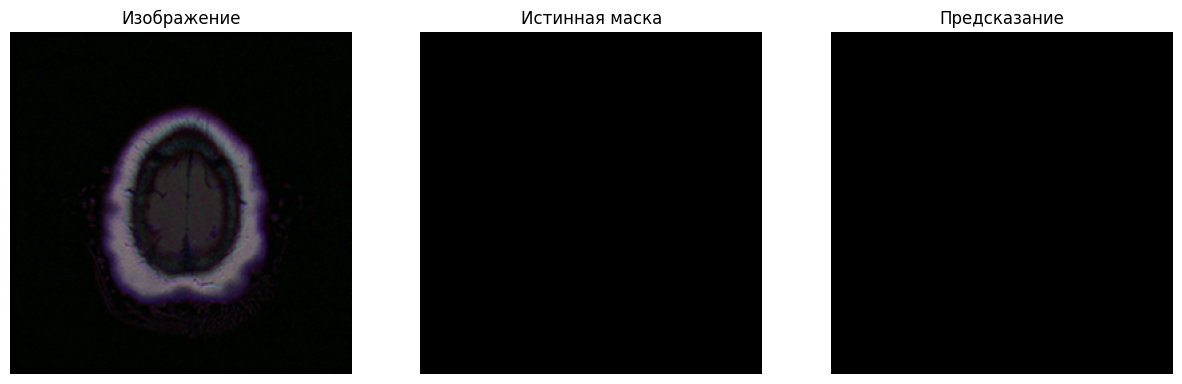

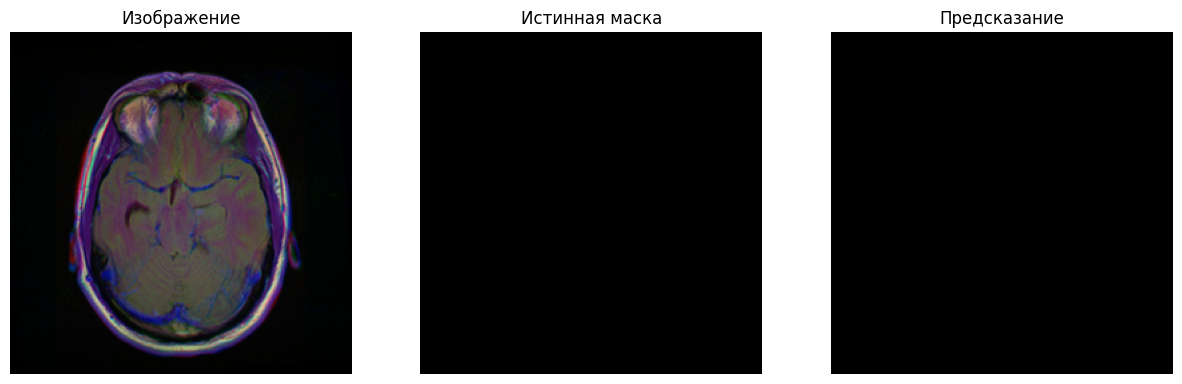

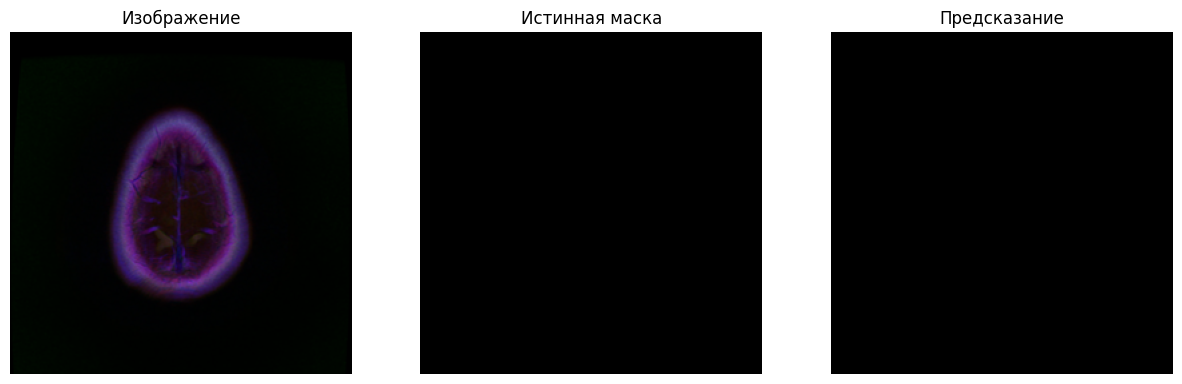

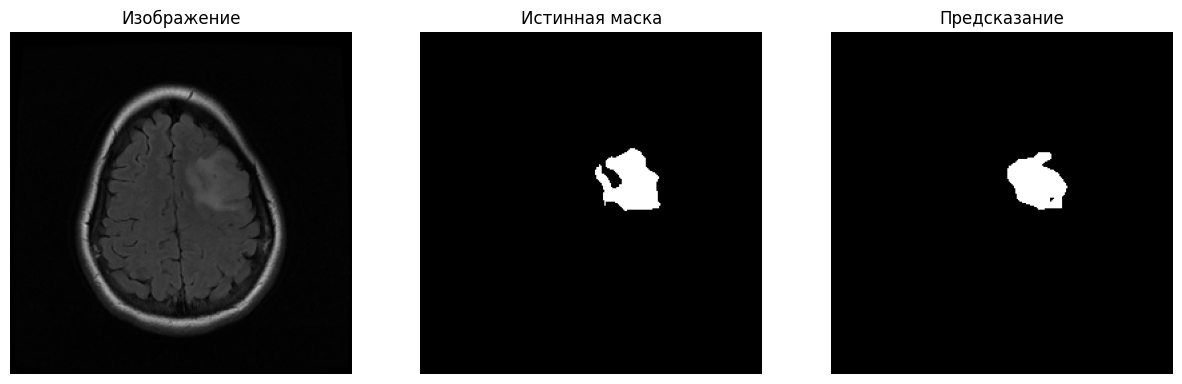

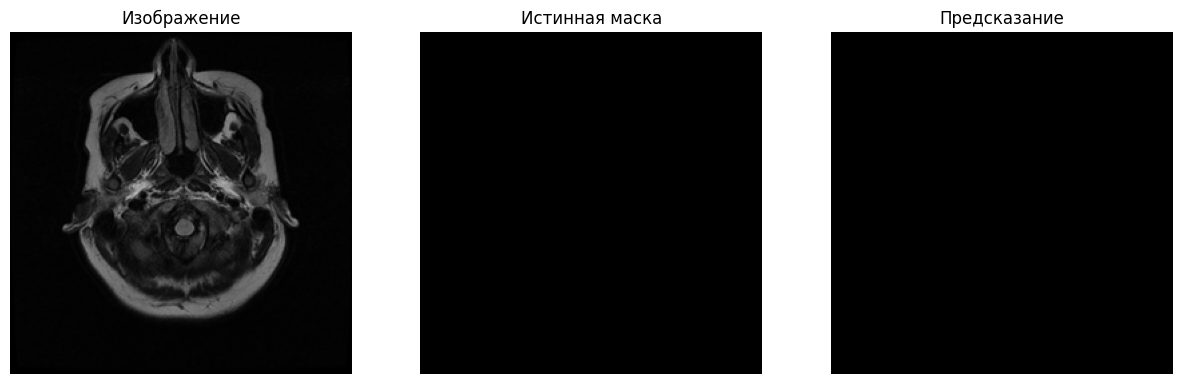

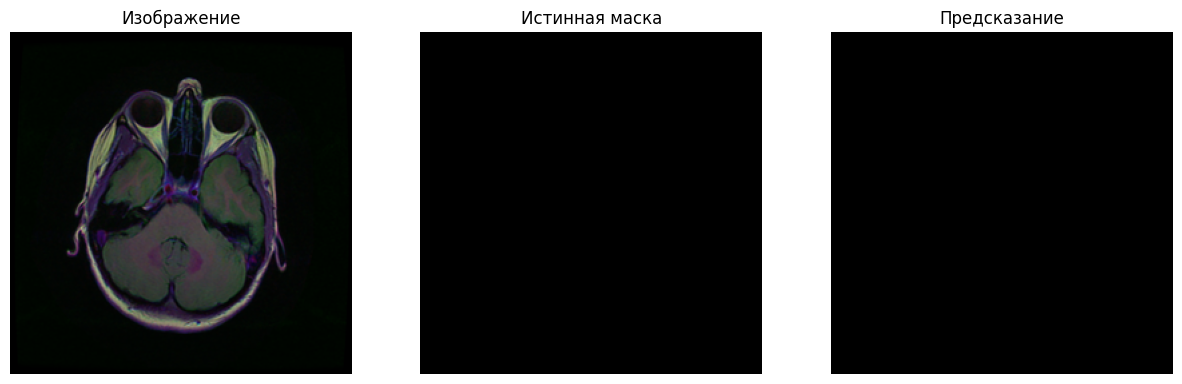

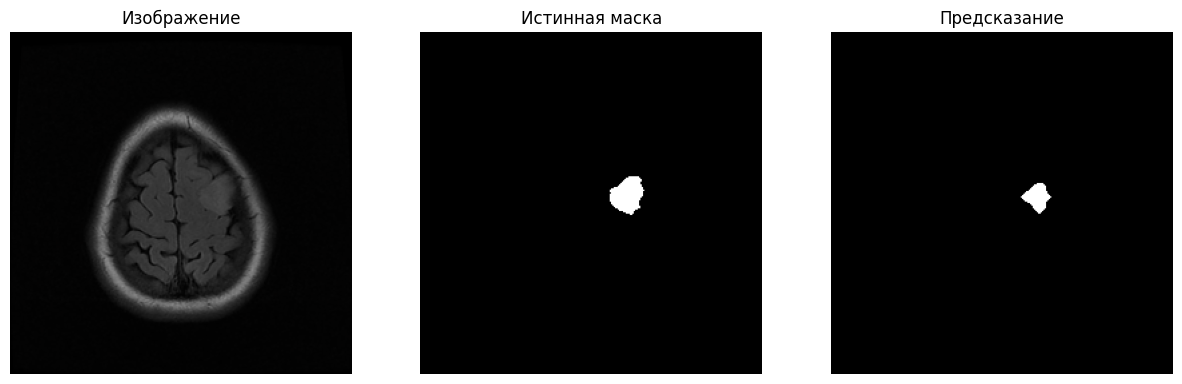

In [15]:
# Инициализация модели DeepLabV3 с ResNet50
load_model = models.segmentation.deeplabv3_resnet50(pretrained=False)
load_model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)

# Перевод модели на устройство
load_model = load_model.to(device)

# Загрузка сохраненных весов с отключением строгой проверки ключей
checkpoint = torch.load('models\DeepLabV3_ResNet50_best_model.pth', map_location=device)
load_model.load_state_dict(checkpoint, strict=False)

# Перевод модели в режим оценки
load_model.eval()

# Визуализация предсказаний
visualize_predictions(load_model, val_loader, device=device, num_images=10)

## U-Net

In [9]:
model = smp.Unet(
    encoder_name="resnet34",       # Кодировщик (backbone)
    encoder_weights="imagenet",    # Предобученные веса на ImageNet
    in_channels=3,                 # Входные каналы, RGB
    classes=1                      # Количество выходных каналов (1 для бинарной сегментации)
)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)

Эпоха 1 из 50: train_loss=0.29352, test_loss=0.72078, val_loss=0.86279, val_IoU=2e-05,
Эпоха 2 из 50: train_loss=0.08217, test_loss=0.07933, val_loss=0.08324, val_IoU=0.4291,
Эпоха 3 из 50: train_loss=0.04341, test_loss=0.06949, val_loss=0.07583, val_IoU=0.44881,
Эпоха 4 из 50: train_loss=0.02751, test_loss=0.04547, val_loss=0.04588, val_IoU=0.48321,
Эпоха 5 из 50: train_loss=0.02082, test_loss=0.03077, val_loss=0.03319, val_IoU=0.5216,
Эпоха 6 из 50: train_loss=0.01596, test_loss=0.01912, val_loss=0.01827, val_IoU=0.63585,
Эпоха 7 из 50: train_loss=0.01207, test_loss=0.01592, val_loss=0.01433, val_IoU=0.72439,
Эпоха 8 из 50: train_loss=0.00991, test_loss=0.01252, val_loss=0.01417, val_IoU=0.71037,
Эпоха 9 из 50: train_loss=0.00876, test_loss=0.01319, val_loss=0.0116, val_IoU=0.75417,
Эпоха 10 из 50: train_loss=0.00805, test_loss=0.01126, val_loss=0.0111, val_IoU=0.74987,
Эпоха 11 из 50: train_loss=0.008, test_loss=0.01465, val_loss=0.01464, val_IoU=0.64971,
Эпоха 12 из 50: train_loss=

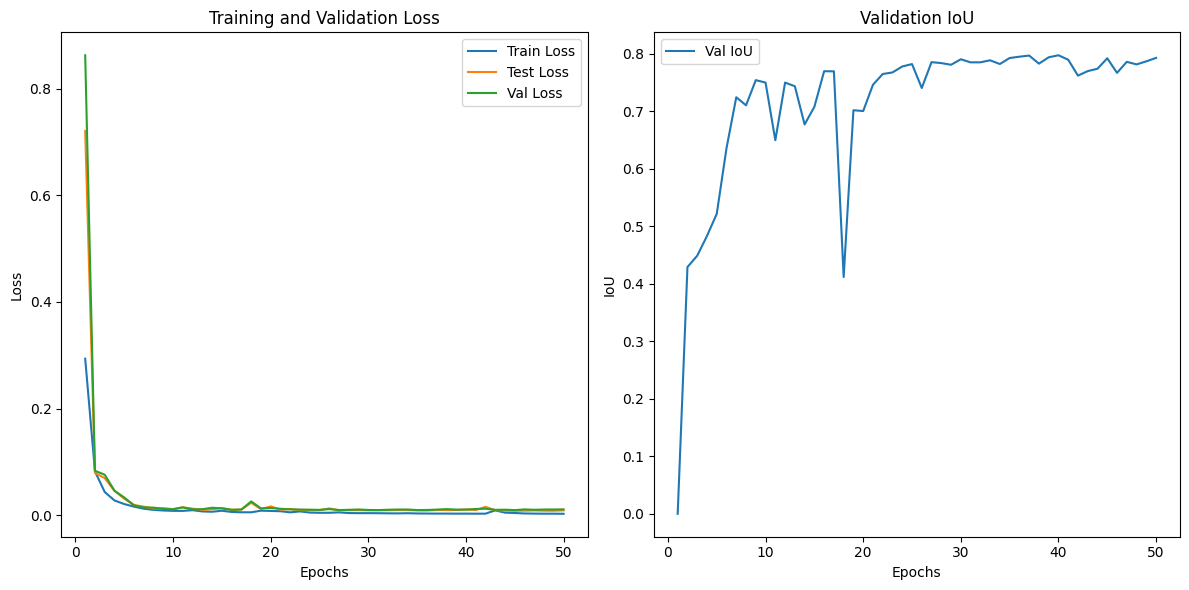

In [10]:
train_and_evaluate(model = model, model_name = 'UNet', num_epochs = 50, 
                   train_loader = train_loader, test_loader = test_loader, val_loader = val_loader, 
                   optimizer = optimizer, criterion = criterion, device = device)

C:\Temp\ipykernel_12736\1355197355.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('models\\UNet_best_model.pth', map_location=device)


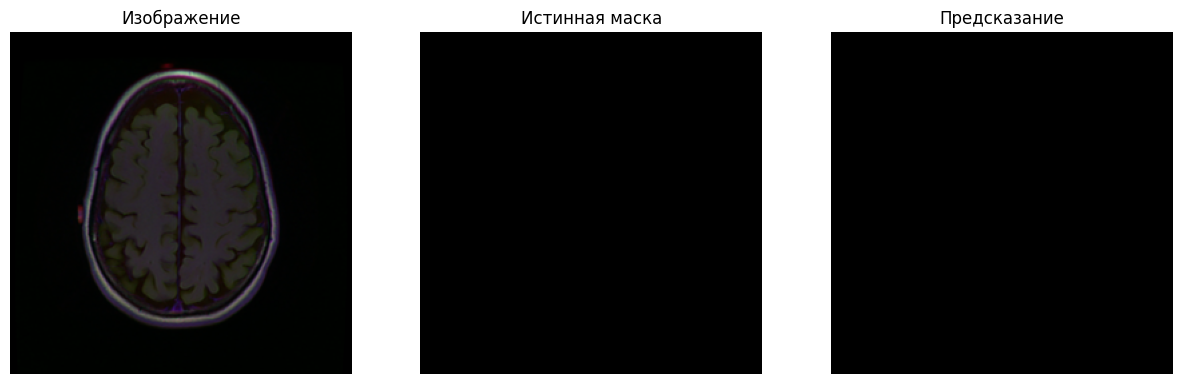

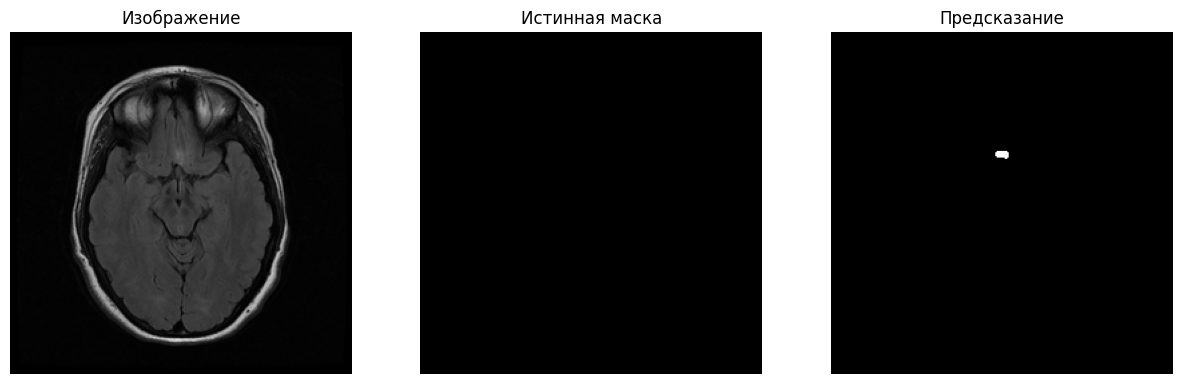

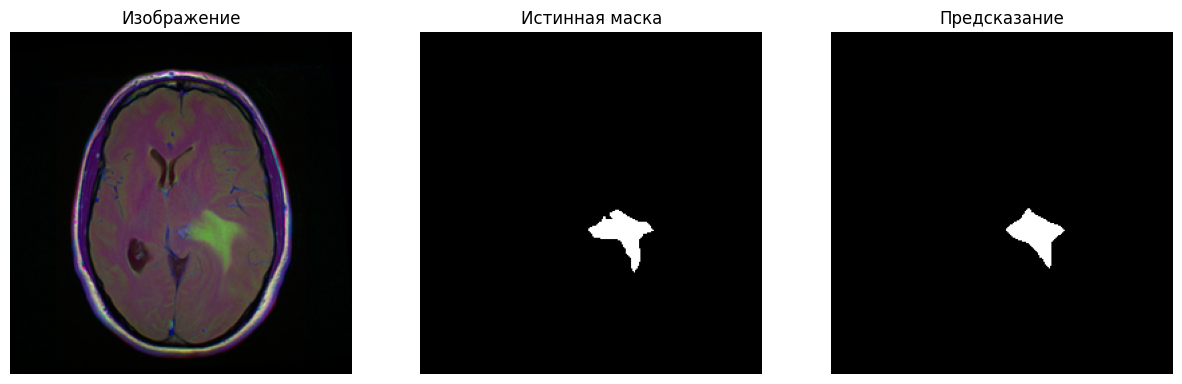

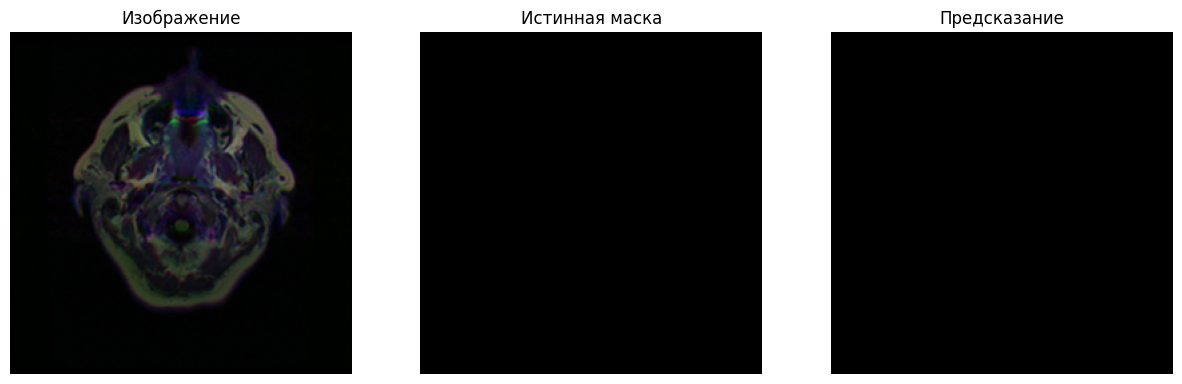

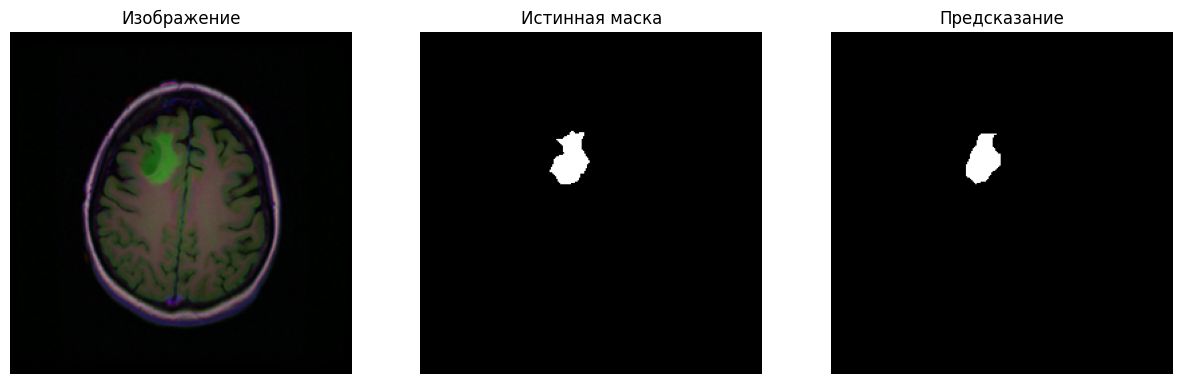

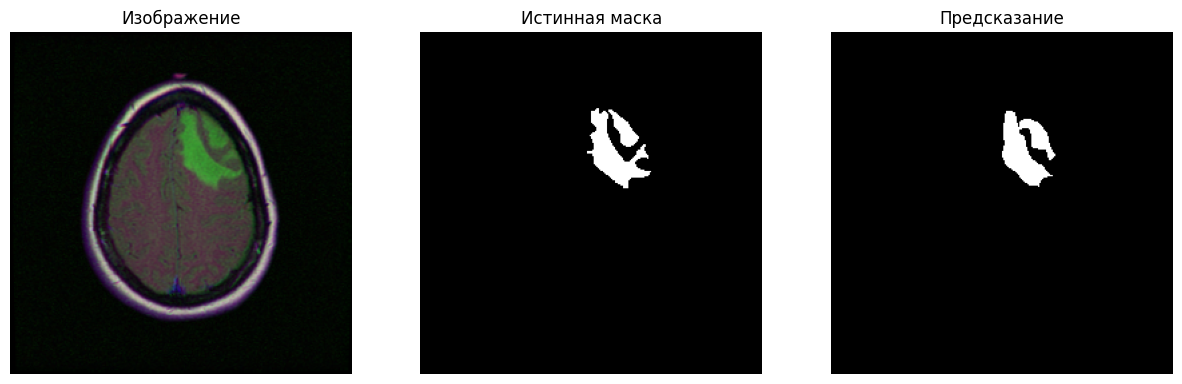

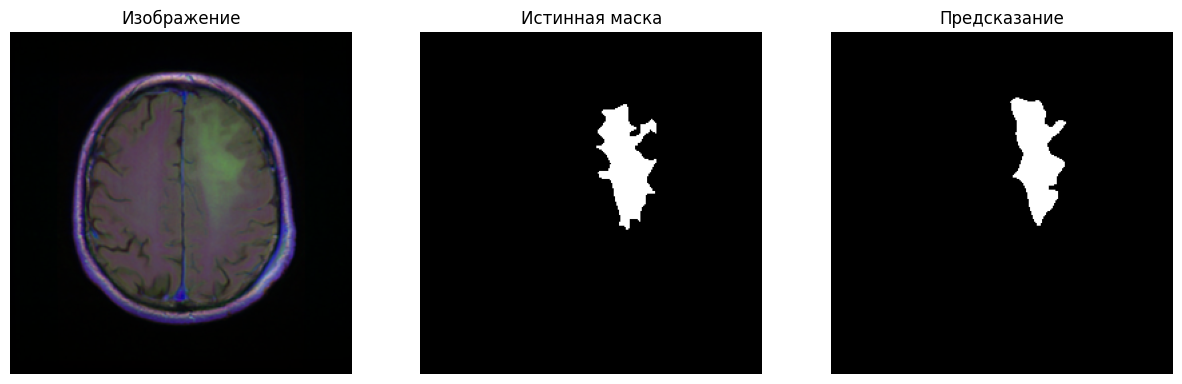

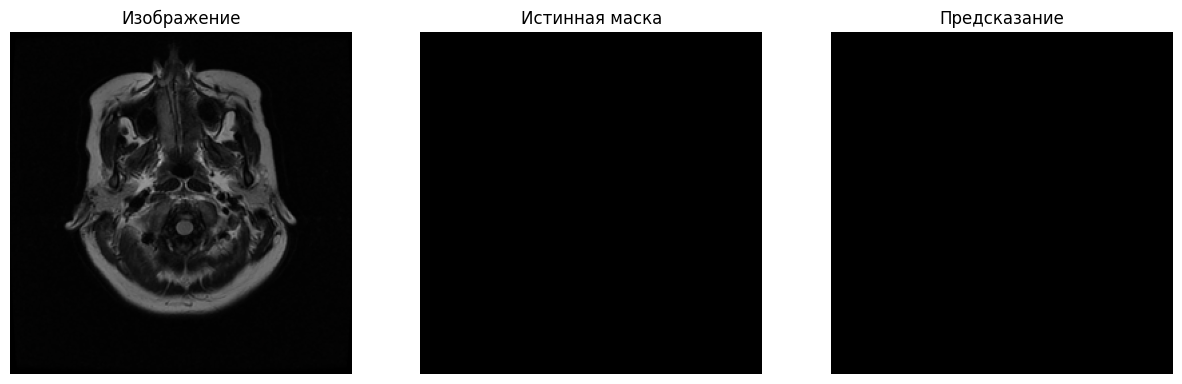

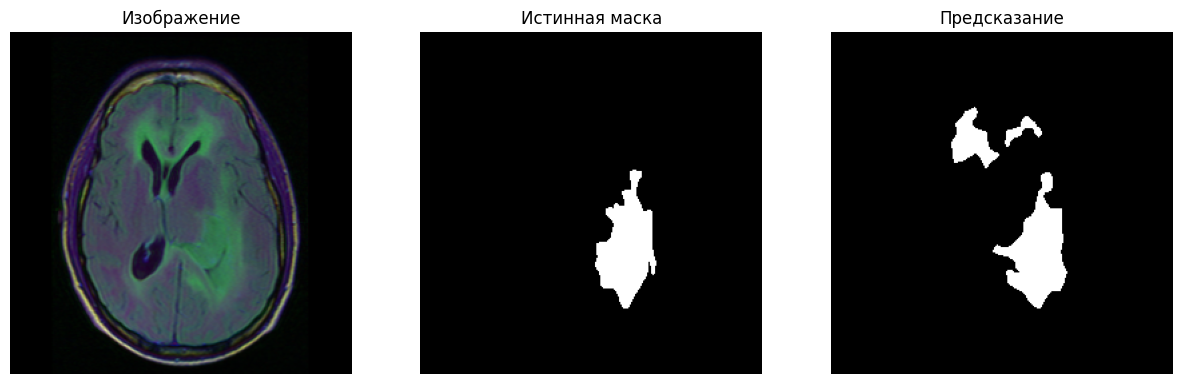

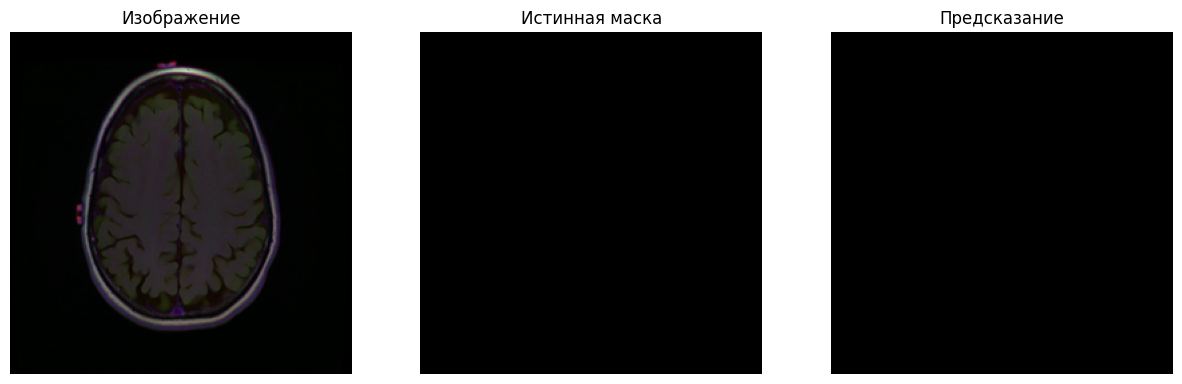

In [14]:
# Инициализация модели с той же конфигурацией
model = smp.Unet(
    encoder_name="resnet34",  # Кодировщик (backbone)
    encoder_weights=None,     # Не загружаем предобученные веса, так как загрузим свои
    in_channels=3,            # Входные каналы (RGB)
    classes=1                 # Количество выходных каналов (бинарная сегментация)
)
model = model.to(device)

# Загрузка сохранённых весов
checkpoint = torch.load('models\\UNet_best_model.pth', map_location=device)
model.load_state_dict(checkpoint)

# Перевод модели в режим оценки
model.eval()

# Визуализация предсказаний
visualize_predictions(load_model, val_loader, device=device, num_images=10)